In [1]:
import matplotlib.pyplot as plt
import torch
import gpytorch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from alse.eci import ExpectedCoverageImprovement
from gpytorch.likelihoods import DirichletClassificationLikelihood
from alse.gp_model import DirichletGPModel

In [2]:
torch.cuda.is_available()

False

If no GPU change "cuda" to "cpu"

In [3]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [4]:
def get_and_fit_gp(X, Y):
    """Simple method for creating a GP with one output dimension.

    X is assumed to be in [0, 1]^d.
    """
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    # octf = Standardize(m=Y.shape[-1])
    # gp = SingleTaskGP(X, Y, likelihood=likelihood, outcome_transform=octf)
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [5]:
def get_and_fit_gp_class(X, Y):
    # Find optimal model hyperparameters
    likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
    model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=2)
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(50):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        optimizer.step()
    return model

In [6]:
def yf(x):
    v = (((x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2)>160).float()
    return v.unsqueeze(-1)

def hills(x):
    v = 0.5*torch.cos(x[:,0]*2-torch.pi)+torch.sin(x[:,1]+torch.pi/2)
    
    return v.unsqueeze(-1)
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return v.unsqueeze(-1)

In [7]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

In [8]:
num_init_points = 5
num_total_points = 15
X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Yhills = hills(X)
Ycircle = circle(X)
Yyf = yf(X)
# plt.scatter(Xhills.cpu().numpy()[:, 0], Xhills.cpu().numpy()[:, 1], c=Yhills.cpu()[:,0])
# plt.scatter(Xcircle.cpu().numpy()[:, 0], Xcircle.cpu().numpy()[:, 1], c=Ycircle.cpu()[:,0])

In [9]:
gp_model_hills = get_and_fit_gp(X, Yhills)
gp_model_circle = get_and_fit_gp(X, Ycircle)
gp_model_class = get_and_fit_gp_class(X.float(), Yyf)
model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

/opt/conda/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [10]:
constraints = [("gt", 0.3), ("gt", 20), ("gt", 0.1)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
i = 1
while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    gp_model_hills = get_and_fit_gp(X, Yhills)
    gp_model_circle = get_and_fit_gp(X, Ycircle)
    gp_model_class = get_and_fit_gp_class(X.float(), Yyf)
    model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512,
    )
    gp_model_hills.eval()
    gp_model_circle.eval()
    gp_model_class.eval()

    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    print(f"New X No. {i}")
    i += 1
    X = torch.cat((X, x_next))
    Yhills = torch.cat((Yhills, hills(x_next)))
    Ycircle = torch.cat((Ycircle, circle(x_next)))
    Yyf = torch.cat((Yyf, yf(x_next)))

/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 1


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 2


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 3


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 4


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 5


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 6


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 7


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 8


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 9


/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


New X No. 10


In [11]:
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)

    these_X = X[..., ]
    direction, value = constraints
    successful[..., ] = (
        these_X < value if direction == "lt" else these_X > value
    )
    return successful

In [12]:
N1, N2 = 200, 200
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt_hills = hills(xplt)
Zplt_hills = torch.reshape(yplt_hills[:, 0], (N1, N2)) 

feasible_inds_hills = (
    identify_samples_which_satisfy_constraints(Yhills, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

/opt/conda/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
yplt_circle = circle(xplt)
Zplt_circle = torch.reshape(yplt_circle[:, 0], (N1, N2)) 

feasible_inds_circle = (
    identify_samples_which_satisfy_constraints(Ycircle, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)


In [14]:
yplt_yf = yf(xplt)
Zplt_yf = torch.reshape(yplt_yf[:, 0], (N1, N2)) 

feasible_inds_yf = (
    identify_samples_which_satisfy_constraints(Yyf, constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)

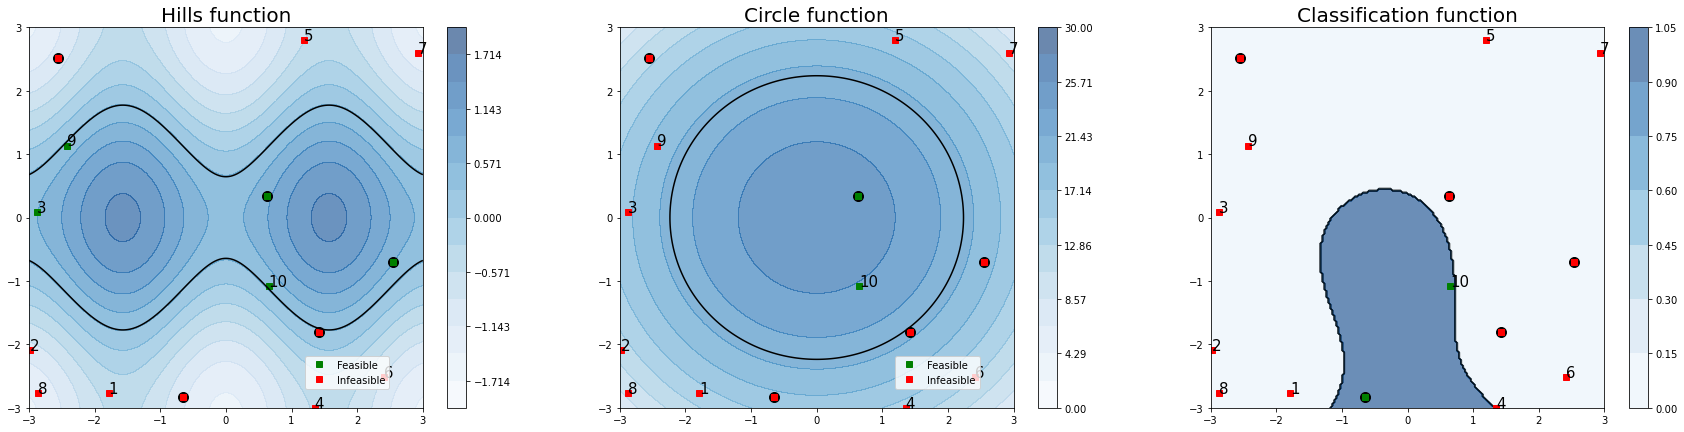

In [15]:
fig, ax = plt.subplots(1,3, figsize=(30, 7))
plot1 = ax[0].contourf(Xplt.cpu(), Yplt.cpu(), Zplt_hills.cpu(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].plot(X[feasible_inds_hills, 0].cpu(), X[feasible_inds_hills, 1].cpu(), "sg", label="Feasible")
ax[0].plot(
    X[~feasible_inds_hills, 0].cpu(), X[~feasible_inds_hills, 1].cpu(), "sr", label="Infeasible"
)
ax[0].scatter(X.cpu()[:5, 0], X.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ind = 1
for i in X[5:]:
    ax[0].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[0].legend(loc=[0.7, 0.05])
ax[0].set_title('Hills function', fontsize=20)

ax[0].contour(Xplt.cpu(), Yplt.cpu(), Zplt_hills.cpu(), [constraints[0][1]], colors="k")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].contourf(Xplt.cpu(), Yplt.cpu(), Zplt_circle.cpu(), levels=np.linspace(0, 30, 15), cmap="Blues", alpha=0.6)
ax[1].plot(X[feasible_inds_circle, 0].cpu(), X[feasible_inds_circle, 1].cpu(), "sg", label="Feasible")
ax[1].plot(
    X[~feasible_inds_circle, 0].cpu(), X[~feasible_inds_circle, 1].cpu(), "sr", label="Infeasible"
)
ax[1].scatter(X.cpu()[:5, 0], X.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ax[1].contour(Xplt.cpu(), Yplt.cpu(), Zplt_circle.cpu(), [constraints[1][1]], colors="k")
ind = 1
for i in X[5:]:
    ax[1].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[1].legend(loc=[0.7, 0.05])
ax[1].set_title('Circle function', fontsize=20)
fig.colorbar(plot2, ax=ax[1], location='right')




plot2 = ax[2].contourf(Xplt.cpu(), Yplt.cpu(), Zplt_yf.cpu(), cmap="Blues", alpha=0.6)
ax[2].contour(Xplt.cpu(), Yplt.cpu(), Zplt_yf.cpu(), colors="k", linewidths=0.3)
ax[2].scatter(X.cpu()[:5, 0], X.cpu()[:5, 1], marker = 'o', s=100, color = 'k')

ax[2].plot(X[feasible_inds_yf, 0].cpu(), X[feasible_inds_yf, 1].cpu(), "sg", label="Feasible")
ax[2].plot(
    X[~feasible_inds_yf, 0].cpu(), X[~feasible_inds_yf, 1].cpu(), "sr", label="Infeasible"
)
ind = 1
for i in X[5:]:
    ax[2].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[2].set_title('Classification function', fontsize=20)
fig.colorbar(plot2, ax=ax[2], location='right')


Calculate Posterior and plot

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30, 7))
pos_yplt_hills = gp_model_hills(xplt).loc
pos_yplt_circle = gp_model_circle(xplt).loc

pos_Zplt_hills = torch.reshape(pos_yplt_hills, (N1, N2))
pos_Zplt_circle = torch.reshape(pos_yplt_circle, (N1, N2))

pos_yplt_yf = gp_model_class(xplt.float())
pred_means = pos_yplt_yf.loc
pred_samples = pos_yplt_yf.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities[0] = probabilities[0]*(probabilities[0].max()-probabilities[0].min())
probabilities[1] = probabilities[1]/probabilities[1].max()
pos_Zplt_yf = probabilities.max(0)[1].reshape((N1,N2))

h1 = ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_hills.cpu().detach(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_hills.cpu().detach(), [0.3], colors="k")
fig.colorbar(h1, ax=ax[0])

h2 = ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_circle.cpu().detach(), levels=np.linspace(0, 30, 15), cmap="Blues", alpha=0.6)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_circle.cpu().detach(), [20], colors="k")
fig.colorbar(h2, ax=ax[1])

h3 = ax[2].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_yf.cpu().detach(), cmap="Blues", alpha=0.6)
ax[2].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_yf.cpu().detach(), colors="k", linewidths=0.3)
fig.colorbar(h3, ax=ax[2])

In [ ]:
probabilities[1]

In [ ]:
probabilities[0]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

levels = np.linspace(0, 1.05, 20)
for i in range(2):
    im = ax[i].contourf(
        Xplt.cpu().detach(), Yplt.cpu().detach(), probabilities[i].numpy().reshape((N1,N2)), levels=levels,
    cmap="Blues", alpha=0.6)
    fig.colorbar(im, ax=ax[i])
    ax[i].plot(X[:,0].numpy(), X[:,1].numpy(), "ko")
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))

ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_yf.cpu().detach(), levels=np.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[0].set_title('True Response', fontsize=20)
ax[0].plot(X[:,0].numpy(), X[:,1].numpy(), "ko")

fig.colorbar(im, ax=ax[0])
                                                       ######### Right here ########
ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_yf,cmap="Blues", alpha=0.6)
ax[1].set_title('Estimated Response', fontsize=20)
fig.colorbar(im, ax=ax[1])
ax[0].plot(X[:,0].numpy(), X[:,1].numpy(), "ko")

In [ ]:
true_overlap = (Zplt_hills > 0.3) & (Zplt_circle > 20) & (Zplt_yf > 0)
pos_overlap = (pos_Zplt_hills > 0.3) & (pos_Zplt_circle > 20) & (pos_Zplt_yf > 0)
true_overlap_points = feasible_inds_circle & feasible_inds_hills & feasible_inds_yf

fig, ax = plt.subplots(1,2, figsize=(17, 7))
ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), true_overlap.cpu().detach(), levels=np.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), (Zplt_hills>0.3).cpu().detach(), colors="k", linewidths=0.3)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), (Zplt_circle>20).cpu().detach(), colors="k", linewidths=0.3)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_yf.cpu().detach(), colors="k", linewidths=0.3)

ax[0].scatter(X.cpu()[:5, 0], X.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ax[0].set_title("True boundary", fontsize=20)
ax[0].plot(X[true_overlap_points, 0].cpu(), X[true_overlap_points, 1].cpu(), "sg", label="Feasible")
ax[0].plot(
    X[~true_overlap_points, 0].cpu(), X[~true_overlap_points, 1].cpu(), "sr", label="Infeasible"
)
ind=1
for i in X[5:]:
    ax[0].text(i[0],i[1],ind, size = 15)
    ind += 1

ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_overlap.cpu().detach(), levels=np.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), (pos_Zplt_hills>0.3).cpu().detach(), colors="k", linewidths=0.3)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), (pos_Zplt_circle>20).cpu().detach(), colors="k", linewidths=0.3)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_yf.cpu().detach(), colors="k", linewidths=0.3)
ax[1].plot(X[true_overlap_points, 0].cpu(), X[true_overlap_points, 1].cpu(), "sg", label="Feasible")
ax[1].plot(
    X[~true_overlap_points, 0].cpu(), X[~true_overlap_points, 1].cpu(), "sr", label="Infeasible"
)
ax[1].set_title("Estimated boundary", fontsize=20)

In [ ]:
reward = pos_overlap & true_overlap
penalty = pos_overlap & ~true_overlap

accuracy = float((reward.sum() - penalty.sum())/true_overlap.sum())
accuracy = round(accuracy, 4)
print(f"Accuracy of this run: {accuracy}")

In [ ]:
reward.sum()

In [ ]:
penalty.sum()

In [ ]:
# if torch.cuda.is_available():
#     import gc
#     import torch
#     gc.collect()
#     torch.cuda.empty_cache()